In [56]:
library(ggplot2)
library(cowplot)
library(umap)
theme_set(theme_bw())

In [21]:
# source files
src_files <- list.files('../../relapse_prediction/R', full.names = TRUE)
for (f in src_files) {
  source(f)
  cat(sprintf('Sourced file: %s\n', f))
}

Sourced file: ../../relapse_prediction/R/batch.R
Sourced file: ../../relapse_prediction/R/calc.R
Sourced file: ../../relapse_prediction/R/gpca.R
Sourced file: ../../relapse_prediction/R/misc.R
Sourced file: ../../relapse_prediction/R/normalise.R
Sourced file: ../../relapse_prediction/R/plot.R
Sourced file: ../../relapse_prediction/R/predict.R
Sourced file: ../../relapse_prediction/R/rvp.R
Sourced file: ../../relapse_prediction/R/subset.R
Sourced file: ../../relapse_prediction/R/utils.R


# Villani
- Villani et al. (2017) - SmartSeq2 (no UMI tag)
- Description in Tran et al. (2020)
- TPM values are stored in file (discovery set)
- Metadata obtained from cell ID (768 cells used)
- 4 cell types, 2 batches
- Batch 1: Plates 7, 8, 9, 10; Batch 2: Plates 3, 4, 13, 14

In [6]:
file <- '../data/villani/GSE94820_raw.expMatrix_DCnMono.discovery.set.submission.txt.gz'
counts <- read.table(file, sep = '\t')

counts1 <- counts[, 1:768]
info <- strsplit(colnames(counts1), split = '_')
coldata <- data.frame(do.call(rbind, info))
colnames(coldata) <- c('celltype', 'patient', 'cell')
batch <- ifelse(coldata$patient %in% c('P7', 'P8', 'P9', 'P10'), 1, 2)
coldata$batch <- as.factor(batch)
rownames(coldata) <- colnames(counts1)

In [8]:
#' @param X Dataframe of dim (n_features, n_samples)
#' @param pct Minimum percentage of samples with value greater than zero
remove_features_dropout <- function(X, pct) X[rowSums(X > 0) >= pct * ncol(X), ]

#' @param X Dataframe of dim (n_features, n_samples)
#' @param pct Minimum percentage of samples with value greater than zero
remove_cells_lowcount <- function(X, pct) X[rowSums(X > 0) < pct * ncol]

[1] 16293   768

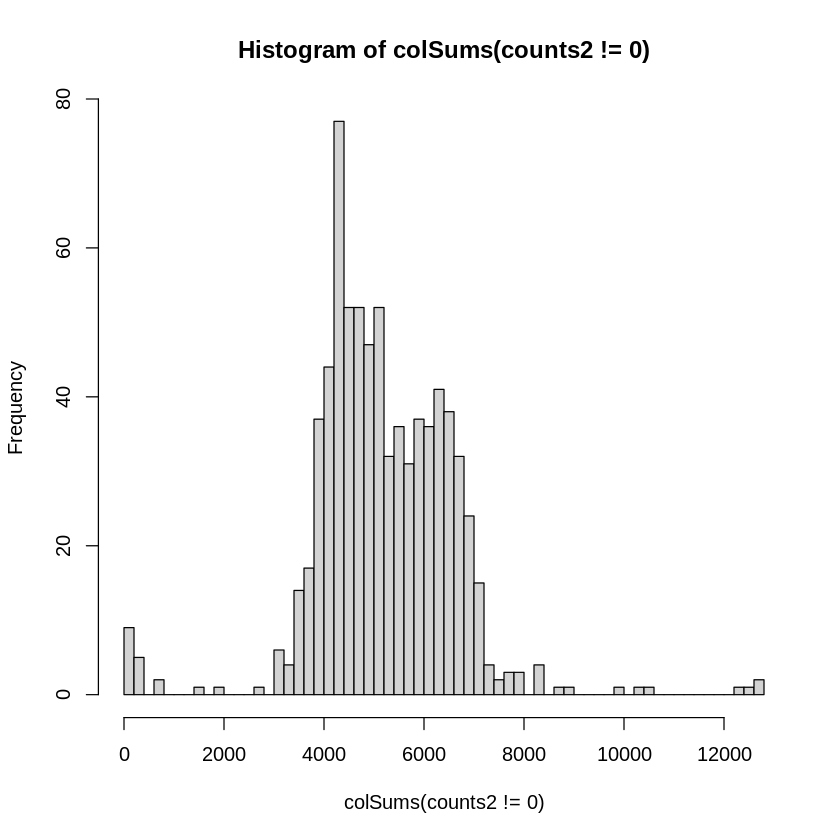

In [10]:
# filter features
counts2 <- remove_features_dropout(counts1, 0.01)
dim(counts2)

# filter doublets and empty cells
# low number of genes detected or low total counts
# filter cells with enriched mitochondrial rna
hist(colSums(counts2 != 0), breaks = 50)
# TODO: Inspect cells with detected < 2000

In [28]:
rvp1 <- RVP(t(counts1), coldata$batch, coldata$celltype, ret.obj = TRUE)
rvp2 <- RVP(t(counts2), coldata$batch, coldata$celltype, ret.obj = TRUE)

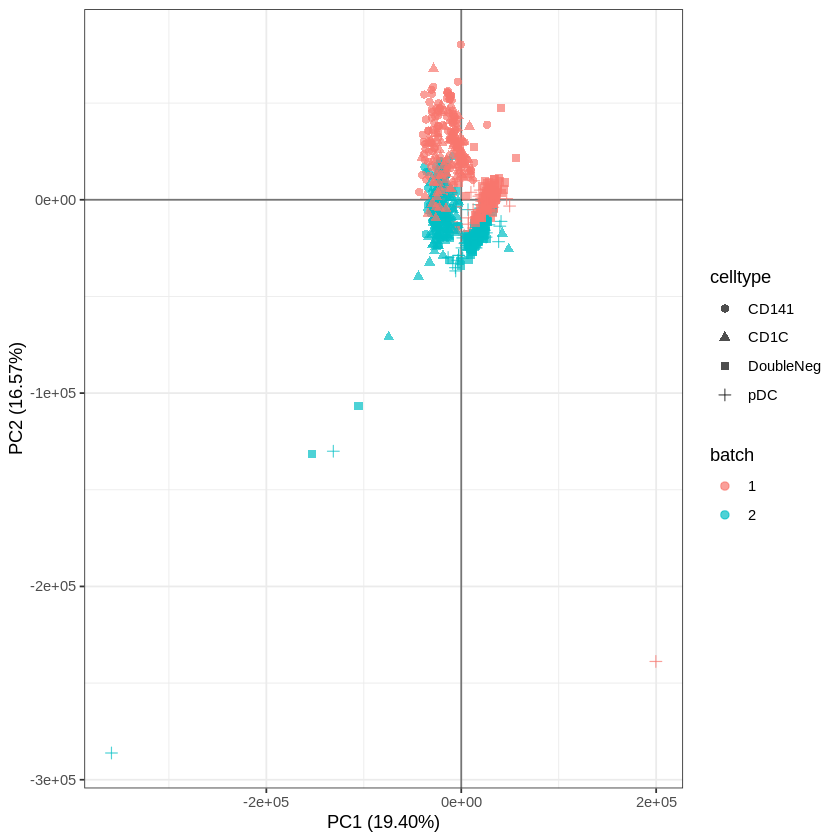

In [47]:
ax1 <- ggplot_pca(counts1, coldata, col = 'batch', pch = 'celltype')
ax1

In [54]:
ax2 <- ggplot_pca(counts2, coldata, col = 'batch', pch = 'celltype', cex = 1)ax2 <- ggplot_pca(counts2, coldata, col = 'batch', pch = 'celltype', cex = 1)

In [55]:
file <- '~/Dropbox/tmp/pca-villani2.pdf'
ggsave(file, ax2, width = 6, height = 4)

In [ ]:
ax3 <- ggplot_umap(t(counts2), coldata, col = 'batch', pch = 'celltype', cex = 1)

In [ ]:
ax3

In [ ]:
ax2 <- ggplot_pca(counts2, coldata, col = 'batch', pch = 'celltype', cex = 1)


In [17]:
rvp <- RVP(t(counts2), coldata$batch, coldata$celltype, ret.obj = TRUE)
SS <- rvp$sum_squares

In [15]:
# sort by ss_total
SS1 <- SS[order(-SS$ss_total), ]
# sort by ss_batch
SS2 <- SS[order(-SS$ss_batch), ]
# sort by rvp
SS3 <- SS[order(-(SS$ss_batch/SS$ss_total)), ]
# sort by average

# sort by average in top

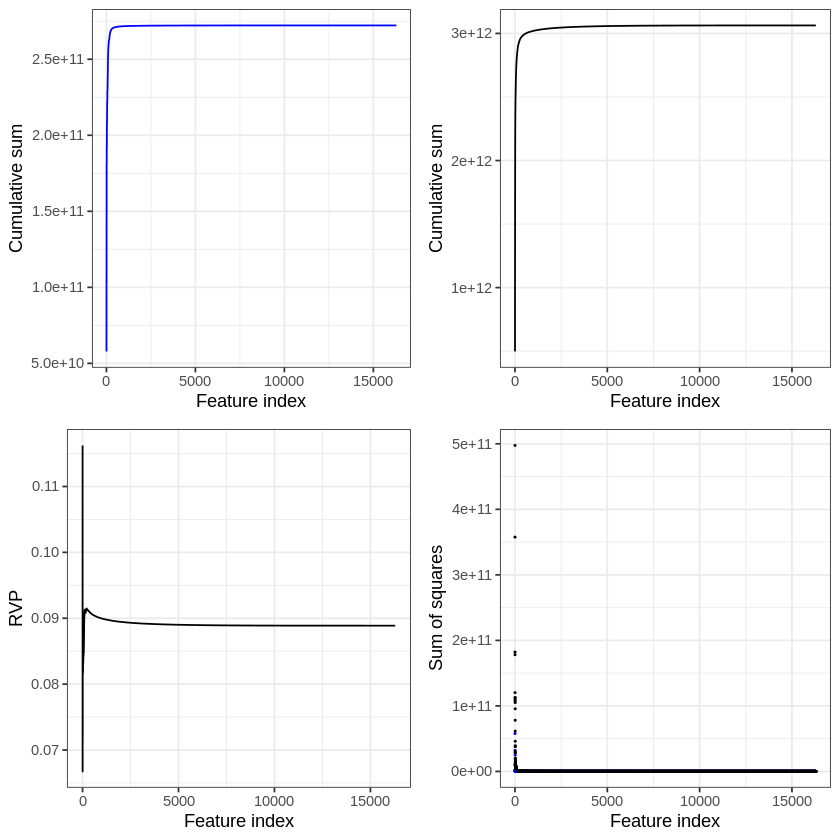

In [27]:
ax <- plot.rvp(SS1, cex = .2)
file <- '~/Dropbox/tmp/simulated_2-rvp_ss3.pdf'
ax
# ggsave(file, ax, width = 5, height = 5)